# **Initialize**

## **Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## **Import packages**

In [ ]:
pip install fastai --upgrade

In [ ]:
! [ -e /content ] && pip install -Uqq fastai 

In [ ]:
!pip install -Uqq fastbook

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import pandas as pd
import pickle
import os

import copy

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split

from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.transforms.functional as tf
from torchvision import models

from fastai.basics import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.vision.widgets import *

import sklearn as sk 

import fastbook
fastbook.setup_book()
from fastbook import *

In [ ]:
#sys.path.append('gdrive/MyDrive/GW_QML_project/GW_Samuel/notebooks/lib')
##!cp gdrive/MyDrive/GW_QML_project/GW_Samuel/notebooks/lib/ML_tools.py .

In [ ]:
#from ML_tools import ML_dataset, SSL_dataset, show

# **Contents**

In [ ]:
!unzip "/content/gdrive/MyDrive/GW_Samuel/datasets/glitches_4s.zip" -d "/content"

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2333.png  
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2334.png  
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2335.png  
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2336.png  
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2337.png  
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2338.png  
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2339.png  
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2340.png  
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2341.png  
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2342.png  
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2343.png  
  inflating: /content/dataset_4s/train/Koi_Fish/glitch_train_4s_2344.png  
  inflating: /content/dataset_4s/train/Ko

In [ ]:
!unzip "/content/gdrive/MyDrive/GW_Samuel/datasets/glitches_all.zip" -d "/content"

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/dataset_all/validation/1080Lines/glitch_validation_half_s_32.png  
  inflating: /content/dataset_all/validation/1080Lines/glitch_validation_half_s_33.png  
  inflating: /content/dataset_all/validation/1080Lines/glitch_validation_half_s_34.png  
  inflating: /content/dataset_all/validation/1080Lines/glitch_validation_half_s_35.png  
  inflating: /content/dataset_all/validation/1080Lines/glitch_validation_half_s_36.png  
  inflating: /content/dataset_all/validation/1080Lines/glitch_validation_half_s_37.png  
  inflating: /content/dataset_all/validation/1080Lines/glitch_validation_half_s_38.png  
  inflating: /content/dataset_all/validation/1080Lines/glitch_validation_half_s_39.png  
  inflating: /content/dataset_all/validation/1080Lines/glitch_validation_half_s_4.png  
  inflating: /content/dataset_all/validation/1080Lines/glitch_validation_half_s_40.png  
  inflating: /content/dataset_all/validation/1080Lin

#**Classes and functions**

##**Datasets**

In [ ]:
class SL_dataset(Dataset):
  def __init__(self, root_path = None, folders = None, transform = None, convert_RGB = False, label_names = None):

    if root_path is None:
      raise Exception("root_path is not defined")

    if folders is None:
      folders = sorted(os.listdir(root_path))

    if label_names is None:
      label_names = folders

    self.root_path = root_path
    self.folders = folders
    self.transform = transform
    self.convert_RGB = convert_RGB
    self.paths = []
    self.labels = []
    self.label_names = label_names

    for i in range(len(folders)):
      paths_group = glob.glob(root_path+folders[i]+'/*')
      self.paths.extend(paths_group)
      #self.labels.extend([torch.eye(len(folders))[i]]*len(paths_group))
      self.labels.extend([i]*len(paths_group))

  def __len__(self):

    return len(self.paths)


  def __getitem__(self,idx):

    path = self.paths[idx]
    image = Image.open(path)
    label = self.labels[idx]

    if self.convert_RGB:
      image = image.convert('RGB')

    if self.transform:
      image = self.transform(image)

    image_tensor = transforms.PILToTensor()(image).float()/255
    
    return image_tensor, label

In [ ]:
class SSL_dataset(Dataset):
  def __init__(self, root_path = None, folders = None, transform = None, convert_RGB = False, label_names = None):

    if root_path is None:
      raise Exception("root_path is not defined")

    if folders is None:
      folders = sorted(os.listdir(root_path))

    if label_names is None:
      label_names = folders

    self.root_path = root_path
    self.folders = folders
    self.transform = transform
    self.convert_RGB = convert_RGB
    self.paths = []
    self.labels = []
    self.label_names = label_names

    for i in range(len(folders)):
      paths_group = glob.glob(root_path+folders[i]+'/*')
      self.paths.extend(paths_group)
    self.labels = [np.random.randint(len(self.transform)) for i in range(len(self.paths))]
    #self.labels = [torch.eye(len(self.transform))[np.random.randint(len(self.transform))] for i in range(len(self.paths))]

  def __len__(self):

    return len(self.paths)

  def __getitem__(self,idx):

    path = self.paths[idx]
    image = Image.open(path)
    label = self.labels[idx]

    if self.convert_RGB:
      image = image.convert('RGB')

    if self.transform:
      image = self.transform[label](image)
      #image = self.transform[label.argmax()](image)

    image_tensor = transforms.PILToTensor()(image).float()/255
    
    return image_tensor, label

## **Models**

In [ ]:
class conv_model(nn.Module):

  def __init__(self, num_classes=1000, in_channels=3):

    super(conv_model, self).__init__()

    #(n of inpt channels, n of out channels/features, size of kernel)
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3,3),stride = (1,1), padding = (1,1))
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),stride = (1,1), padding = (1,1))
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3),stride = (1,1), padding = (1,1))
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3),stride = (1,1), padding = (1,1))

    self.maxPool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.bn2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.bn3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.bn4 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    self.fc1 = nn.Linear(512, num_classes, True)

    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    
    x = F.relu(self.conv1(x))
    x = self.bn1(x)
    x = self.maxPool(x)

    x = F.relu(self.conv2(x))
    x = self.bn2(x)
    x = self.maxPool(x)
    
    x = F.relu(self.conv3(x))
    x = self.bn3(x)
    x = self.maxPool(x)
    
    x = F.relu(self.conv4(x))
    x = self.bn4(x)
    x = self.maxPool(x)

    #the new shape will be: (batch, out_channels, 1, 1)
    x = self.avgpool(x)
    #remove extra dimentions
    x = x.reshape(x.shape[0],-1) 
    #fully connected
    x = self.fc1(x)
    
    x = self.softmax(x)

    return x

In [ ]:
x = torch.randn(64,3,128,128)
x = conv_model()(x)
x.shape

torch.Size([64, 1000])

In [ ]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def simple_loss(predictions, targets): 
  predictions = predictions.sigmoid()
  return torch.where(targets == 1, 1-predictions, predictions).mean()

##**Functions**

In [ ]:
def show(sample):
  image = sample[0]
  label = sample[1]
  image = image.permute(1, 2, 0)
  print('label: {0}'.format(label))
  plt.axis('off')
  plt.imshow(image)

# **Datasets and dataloaders**

In [ ]:
path = "./dataset_4s"
#path = str(untar_data(URLs.DOGS))
train_path = path+'/train/'
valid_path = path+'/validation/'
test_path = path+'/test/'

path_SSL = "./dataset_all"
train_path_SSL = path_SSL+'/train/'
valid_path_SSL = path_SSL+'/validation/'
test_path_SSL = path_SSL+'/test/'

folders = None
convert_RGB=True
label_names = ['crop', 'rotate', 'flip', 'colorize']

In [ ]:
os.listdir(path_SSL)

['validation', 'train', 'test']

In [ ]:
# original size is [3, 140, 170]
image_dim = (128,128)
crop_size = (135,135)

center_crop =  transforms.CenterCrop(crop_size)
rand_crop =  transforms.RandomCrop(crop_size)
resize = transforms.Resize(size=image_dim, interpolation=transforms.InterpolationMode.NEAREST)
resize_and_crop = transforms.Compose([center_crop,resize])

transform_SSL = [resize,
                 resize_and_crop,
                 transforms.Compose([transforms.RandomRotation((90,90), interpolation=NEAREST, fill=(70, 11, 94)), resize]),
                 transforms.Compose([transforms.RandomRotation((270,270), interpolation=NEAREST, fill=(70, 11, 94)), resize]),
                 transforms.Compose([transforms.RandomVerticalFlip(p=1), resize]),
                 transforms.Compose([transforms.RandomHorizontalFlip(p=1), resize]),
                 transforms.Compose([transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5,hue=[-.1, .1]), resize])]

transform_SL = transforms.Compose([transforms.RandomRotation((-5,5), interpolation=NEAREST, fill=(70, 11, 94)),transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5,hue=[-.1, .1]),rand_crop,resize])

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

original_ds = SL_dataset(root_path="./dataset_all/validation/",
                      folders=folders,
                      transform=transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5,hue=[-.1, .1]),
                      convert_RGB=convert_RGB)

train_ds = SL_dataset(root_path=train_path,
                      folders=folders,
                      transform=transform_SL,
                      convert_RGB=convert_RGB)

valid_ds = SL_dataset(root_path=valid_path,
                      folders=folders,
                      transform=resize_and_crop,
                      convert_RGB=convert_RGB)

test_ds = SL_dataset(root_path=test_path,
                     folders=folders,
                     transform=resize_and_crop,
                     convert_RGB=convert_RGB)

train_trf_ds = SSL_dataset(root_path=train_path_SSL,
                           folders=folders,
                           transform=transform_SSL,
                           convert_RGB=convert_RGB,
                           label_names=label_names)

valid_trf_ds = SSL_dataset(root_path=valid_path_SSL,
                           folders=folders,
                           transform=transform_SSL,
                           convert_RGB=convert_RGB,
                           label_names=label_names)

test_trf_ds = SSL_dataset(root_path=test_path_SSL,
                          folders=folders,
                          transform=transform_SSL,
                          convert_RGB=convert_RGB,
                          label_names=label_names)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
batch_size = 32
print("Cuda is available: ",torch.cuda.is_available())

Cuda is available:  True


In [ ]:
len(train_trf_ds)

24032

label: 5


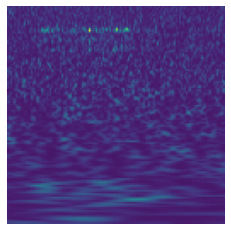

In [ ]:
index = 0
data_sample = valid_trf_ds[index]
show(data_sample)

./dataset_all/validation/Chirp/glitch_validation_1s_378.png
label: 4


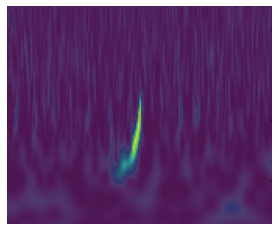

In [ ]:
index = 1510
print(original_ds.paths[index])
data_sample = original_ds[index]
show(data_sample)

In [ ]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=batch_size, device=device)
dls_trf = DataLoaders.from_dsets(train_trf_ds, valid_trf_ds, bs=batch_size, device=device)

In [ ]:
criterion = nn.CrossEntropyLoss()
opt_func = Adam
metrics = [accuracy,F1Score(average='macro')]
log_path = Path('/content/gdrive/MyDrive/GW_Samuel/logs')

# **Learn: Transform dataset**

Minimum/10 is 0.00036307806149125097


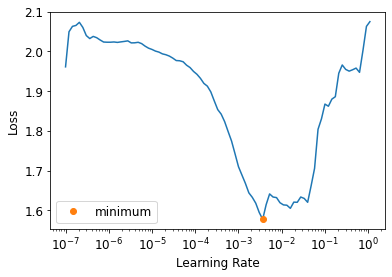

In [ ]:
learn_trf = Learner(dls=dls_trf,
                    model=models.resnet18(num_classes=len(transform_SSL)),
                    path=log_path, loss_func=criterion,
                    opt_func=opt_func,
                    metrics=metrics,
                    cbs=[ShowGraphCallback(), CSVLogger(fname='SSL_model.csv'), SaveModelCallback(monitor='valid_loss', every_epoch=True, fname='SSL_model')])

get_lr = learn_trf.lr_find(suggest_funcs=(minimum))
print(f'Minimum/10 is {get_lr.minimum}')

In [ ]:
lr = get_lr.minimum
print(f'The learning rate is {lr}')

The learning rate is 0.00036307806149125097


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.343709,0.316358,0.852679,0.858284,01:02
1,0.208198,0.198294,0.924884,0.925985,01:02
2,0.151875,0.225849,0.902950,0.905836,01:00
3,0.123103,0.354019,0.842003,0.829131,01:00
4,0.097997,0.158296,0.937888,0.940056,01:03
5,0.075837,0.099227,0.954193,0.955203,01:01
6,0.057501,0.107182,0.953610,0.954588,01:00
7,0.024959,0.124606,0.959821,0.960884,01:03
8,0.008070,0.134028,0.961374,0.962418,01:01
9,0.004984,0.143625,0.960598,0.961686,01:01


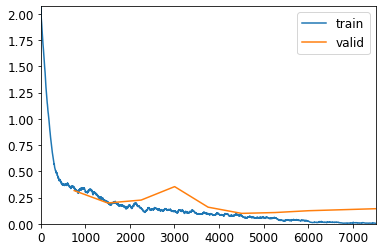

In [ ]:
learn_trf.fit_one_cycle(10,lr_max=lr)

# **Re-Learn: from previous dataset**

Minimum/10 is 0.003981071710586548


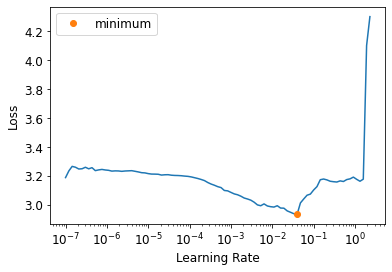

In [ ]:
learn_new = Learner(dls=dls,
                    model=models.resnet18(num_classes=len(transform_SSL)),
                    path=log_path,
                    loss_func=criterion,
                    opt_func=opt_func,
                    metrics=metrics,
                    cbs=[ShowGraphCallback(), CSVLogger(fname='SL_on_SLL_model.csv'), SaveModelCallback(monitor='valid_loss', every_epoch=True, fname='SL_on_SLL_model')])
model_name = 'SSL_model_8.pth'
state_dict = torch.load('/content/gdrive/MyDrive/GW_Samuel/logs/models/'+model_name, map_location=torch.device('cpu'))
learn_new.load_state_dict(state_dict)
learn_new.model.fc = nn.Linear(in_features=512, out_features=len(train_ds.folders), bias=True)

get_lr = learn_new.lr_find(suggest_funcs=(minimum))
print(f'Minimum/10 is {get_lr.minimum}')

In [ ]:
lr = get_lr.minimum
print(f'The learning rate is {lr}')

The learning rate is 0.003981071710586548


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.809508,1.316419,0.577640,0.266897,00:29
1,0.794525,0.428295,0.871118,0.697614,00:27
2,0.516370,0.368890,0.896739,0.742022,00:27
3,0.393630,0.260975,0.921584,0.817488,00:29
4,0.300823,0.223130,0.937888,0.825805,00:27
5,0.230602,0.194967,0.944099,0.869153,00:28
6,0.199709,0.171108,0.954193,0.872543,00:28
7,0.139018,0.163925,0.958075,0.897566,00:28
8,0.120225,0.140320,0.958851,0.901026,00:28
9,0.104010,0.141744,0.963509,0.914607,00:28


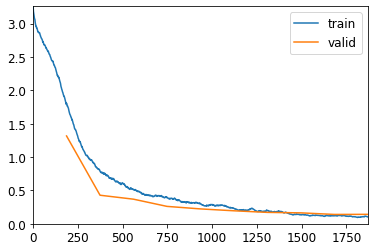

In [ ]:
learn_new.freeze()
learn_new.fit_one_cycle(10,lr_max=lr)

In [ ]:
learn_new.unfreeze()

Minimum/10 is 1.2022644114040304e-06
steep is 1.0964781722577754e-06


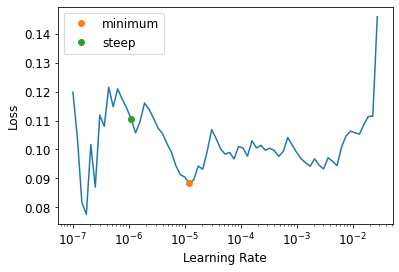

In [ ]:
get_lr = learn_new.lr_find(suggest_funcs=(minimum, steep))
print(f'Minimum/10 is {get_lr.minimum}')
print(f'steep is {get_lr.steep}')

In [ ]:
print(f'The learning rate is {lr/10}')

The learning rate is 0.0003981071710586548


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.088105,0.143454,0.962733,0.914696,00:27
1,0.108574,0.136163,0.965062,0.916059,00:28
2,0.107832,0.135067,0.959627,0.911833,00:27
3,0.100258,0.140659,0.961180,0.915089,00:28
4,0.101508,0.133782,0.963509,0.915443,00:28
5,0.097136,0.150397,0.957298,0.908651,00:28
6,0.095470,0.137544,0.965838,0.913741,00:30
7,0.081800,0.152492,0.959627,0.903410,00:28
8,0.094231,0.149388,0.958851,0.904556,00:28
9,0.078237,0.134850,0.964286,0.911359,00:28


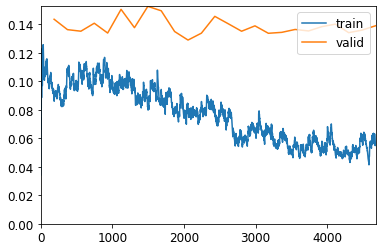

In [ ]:
learn_new.fit_one_cycle(25,lr_max=lr/10)

# **Learn: Normal dataset**

In [ ]:
models.resnet18(num_classes=len(train_ds.folders))

Minimum/10 is 0.005754399299621582


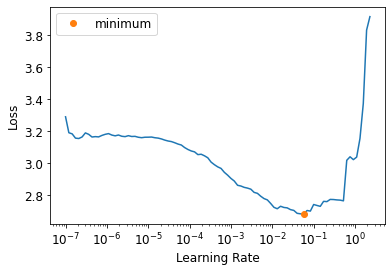

In [ ]:
learn = Learner(dls=dls,
                model=models.resnet18(num_classes=len(train_ds.folders)),
                path=log_path,
                loss_func=criterion,
                opt_func=opt_func,
                metrics=metrics,
                cbs=[ShowGraphCallback(), CSVLogger(fname='SL_model.csv'), SaveModelCallback(monitor='valid_loss', every_epoch=True, fname='SL_model')])

get_lr = learn.lr_find(suggest_funcs=(minimum))
print(f'Minimum/10 is {get_lr.minimum}')

In [ ]:
lr = get_lr.minimum
print(f'The learning rate is {lr}')

The learning rate is 0.005754399299621582


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.758416,0.583046,0.818323,0.681077,00:26
1,0.556575,0.441407,0.875776,0.740212,00:26
2,0.543572,0.497760,0.843168,0.701815,00:26
3,0.477949,0.416982,0.891304,0.783196,00:26
4,0.511961,0.517819,0.852484,0.701958,00:26
5,0.421601,0.474902,0.864130,0.724073,00:26
6,0.372084,0.298625,0.903727,0.775000,00:28
7,0.348363,0.465326,0.886646,0.763985,00:26
8,0.277084,0.224933,0.927019,0.835088,00:26
9,0.264066,0.268028,0.916925,0.824569,00:26


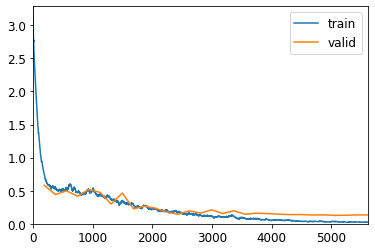

In [ ]:
learn.fit_one_cycle(30, lr_max=lr)